# Lab4: Constrained optimization: equality and inequality constraints

**Carla Sendra Balcells**\
**Roxane Le Tensorer**\
**Rachel Trimble**

In [30]:
import numpy as np
import matplotlib.pyplot as plt
#from QPGC_3_8 import *
from QPGC import *
import tqdm
from sklearn.utils import shuffle

The problem we want to solve is the following one:

Minimize $f(\alpha)=\sum_{i=1}^{m} -\alpha_i + \dfrac{1}{2} \alpha^T(YX^T XY)\alpha  $<br>
Subject to $\sum_{i=1}^{m} y_i \alpha_i = 0 \;\;\;,\;\;\;0 \leq \alpha_i \leq K $<br>

But we will try to convert it to this notation in order to implement it using the dual formulation :

Minimize $f(x)=\dfrac{1}{2} x^T G x + g^T x $<br>
Subject to $A^T x=b \;\;\;,\;\;\;C^T x \geq d$ or in order to fit it in our problem $d_{low} \leq C^T x  \leq d_{high}$ and what is the same $d_{low} \leq C^T x, -d_{high} \leq -C^T x$<br>

So, we could define:

$G = Y X^T XY$\
$x = \alpha$\
$g^T = -[1,1,...n]$\
$A = y$\
$b = 0$\
$C = [C_1, C_2]$ where $C_1=Id$ and $C_2=-Id$\
$d = [d_1, d_2]^T$ where $d_1=[0,0,..n]$ and $d_2=-[k_1, k_2...k_n]$

$G\in R^{nxn}$,
$x\in R^{n}$,
$g\in R^{n}$,
$A\in R^{nxp}$,
$C\in R^{nxm}$,
$C_1\in R^{nxn}$
$C_2\in R^{nxn}$
$b\in R^{p}$,
$d\in R^{m}$,
$d_1\in R^{n}$, 
$d_2\in R^{n}$, 
$Y\in R^{nxn}$,
$y\in R^{n}$,
$X\in R^{mxn}$,
$\alpha \in R^{n}$,
$K \in R^{m}$

where n are the number of samples (n=200) and m the number of constraints (m=200x2), p=1. 

First of all, we create a function able to generate the two datasets based on the given means and covariances. There are two different situations: if the datasets are separable, it means that it is possible to find an hyperplane that will strictly divide the two sets, meaning that absolutely no value will be in the wrong category. On the contrary, if the datasets are non separable, no hyperplane will be able to strictly divide the two sets. It means that, in this second situation, the hyperplane should try to minimize the errors of classification. <br>
This is the reason why the generate_dataset algorithm takes two parameters which are the separable or not aspect of the datasets, and also the number of values in each dataset. 

In [31]:
def generate_dataset(N, separable):
    m1 = [0, 0]
    s1 = [[1, -0.9], [-0.9, 1]]
    s2 = [[1, 0], [0, 1]]
    if separable:
        m2 = [3, 6]
    else:
        m2 = [1, 2]
    cluster_1 = np.random.multivariate_normal(m1, s1, N)
    cluster_2 = np.random.multivariate_normal(m2, s2, N)
    X = np.concatenate([cluster_1, cluster_2]).T
    Y = np.diag(np.concatenate([np.ones(cluster_1.shape[0]), -np.ones(cluster_2.shape[0])]))
    return X, Y, cluster_1, cluster_2

We create now an algorithm ploting the two datasets, in order to visualize the difference between separable datasets and non-separable datasets.

In [32]:
def plot_both_clusters(N):
    _, _, c1s, c2s = generate_dataset(N,True)
    _, _, c1n, c2n = generate_dataset(N, separable=False)

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(121)
    ax.plot(c1s[:, 0], c1s[:, 1], marker='o', linestyle='None', alpha=0.7)
    ax.plot(c2s[:, 0], c2s[:, 1], marker='o',linestyle='None', alpha=0.7)
    ax.set_title("Separable problem")

    ax = fig.add_subplot(122)
    ax.plot(c1n[:, 0], c1n[:, 1], marker='o', linestyle='None', alpha=0.7)
    ax.plot(c2n[:, 0], c2n[:, 1], marker='o',linestyle='None', alpha=0.7)
    ax.set_title("Non-separable problem")


    plt.show()

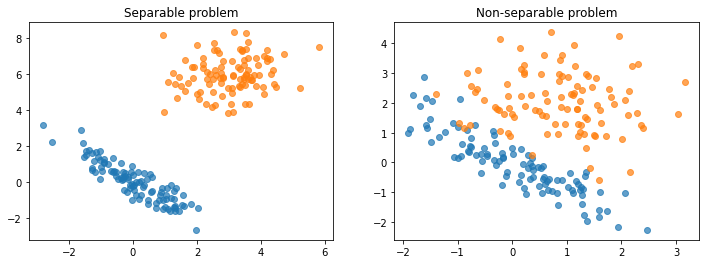

In [33]:
plot_both_clusters(100)

As we can easily see in this example, in the first case, we can visualize a line sharing the space in order to set the blue points in one side and the orange points in the other side. However, this is not possible in the second case, because points are much closer and some of them mix and overlap.  

## Separable Dataset

### 1. Simple case (N=2)

In [34]:
N=2
X, Y, cluster1, cluster2 = generate_dataset(N,True)
X.shape, Y.shape, cluster1.shape, cluster2.shape

((2, 4), (4, 4), (2, 2), (2, 2))

As explained at the beginning of the lab, we will use the notation: <br>
Minimize $f(x)=\dfrac{1}{2} x^T G x + g^T x $<br>
Subject to $A^T x=b \;\;\;,\;\;\;C^T x \geq d$<br>
So we have to determine the value of each parameter. For this, we define a function "param" to convert X, Y into the desired notation in order to compile the dual problem.

In [35]:
def param(X, Y, K=1):
    n = X.shape[1]
    
    G = np.dot(np.dot(np.dot(Y,X.T),X),Y)
    g = -np.ones(n)
    A = np.expand_dims(np.diag(Y), axis=0).T
    b = np.zeros(1)
    
    C1 = np.eye(n)
    C2 = -np.eye(n)
    d1 = np.zeros(n)
    d2 = -np.ones(n)*K
    C = np.concatenate((C1,C2), axis=1)
    d = np.concatenate((d1,d2), axis=0)
    
    return G, g, A, C, b, d

In [36]:
G, g, A, C, b, d = param(X, Y, K=1)
G.shape, g.shape, A.shape, C.shape, b.shape, d.shape

((4, 4), (4,), (4, 1), (4, 8), (1,), (8,))

Once the dual problem has been solved and the optimal value of $\alpha$ is acquired, the parameters $w$ and $b$ can be solved utilizing the below formulas: <br>

$w = \sum_{i=1}^m\alpha_iy_ix_i$\
$b = \frac{1}{y_j}-w^Tx_j$

where $\alpha \in R^2$ and $b\in R^1$

Moreover, $x_j$ and $y_j$ are the ones with the $\alpha$ that gets a higher minimization at $f(\alpha)$, for this reason $\alpha_j$ should be the one with a highest value. 

In [37]:
def sol(X, Y, alpha):
    w = np.dot(X,np.diag(alpha*Y))
    j = np.argmax(alpha)
    b = Y[j,j]-np.dot(w,X[:,j])
    return w,b

In [38]:
def plot_svm(plot_information): 
    nb_figures = len(plot_information)
    fig = plt.figure(figsize=(4*nb_figures, 4))
    
    for figure in range(0,nb_figures):
        cluster_1,cluster_2, w, b = plot_information[figure]
    
        x_plot,y_plot = np.meshgrid(np.linspace(-5,7,100),np.linspace(-4,10,100))
        mesh = np.c_[x_plot.ravel(),y_plot.ravel()]     
        z = np.dot(mesh,w)+b

        ax = fig.add_subplot(100+nb_figures*10+figure+1)
        ax.plot(cluster_1[:,0],cluster_1[:,1],color='c', marker='o', linestyle='None', alpha=0.7)
        ax.plot(cluster_2[:,0],cluster_2[:,1],color='orange', marker='o',linestyle='None', alpha=0.7)
        ax.contour(x_plot,y_plot,z.reshape((100,100)),[-1.,0.,1.])

    plt.show()

We now run the algorithm, setting the parameter K as 1.

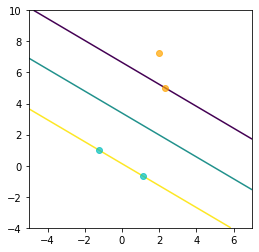

w:[-0.21654355 -0.30675654] b:1.0399633208151986


In [39]:
K=1

G, g, A, C, b, d = param(X, Y, K)
alpha = QPGenericConstraints(G, g, A, C, b, d)

w, b = sol(X, Y, alpha)

plot_information = np.array([[cluster1,cluster2,w,b]])

plot_svm(plot_information)
print('w:'+str(w)+' b:'+str(b))

We observe that there is a critical subset of data points. These are called Support Vectors. If any of those points disappear the boundary changes. The "maximum-margin hyperplane" formed from these support vectors divides the clusters for which $y_i=1$ from the group of points for which $y_i=-1$, which is defined so that the distance between the hyperplane and the nearest point from either group is maximized. 

The algorithm seems to have been succesful at separating the separable data into two distinct groups.

We can now try with a higher number N of points.

### 2. Simple case (N=100)

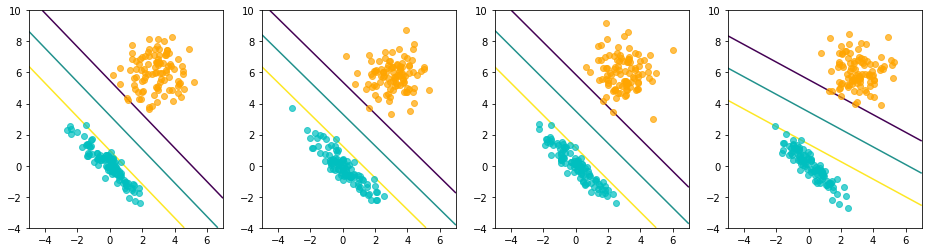

In [40]:
N=100

info = []

for i in range(0,4):
    X, Y, cluster1, cluster2 = generate_dataset(N,True)
    G, g, A, C, b, d = param(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    
    newInfo = [cluster1,cluster2,w,b]
    info.append(newInfo)

plot_information = np.array(info)

plot_svm(plot_information)
#print('w:'+str(w)+' b:'+str(b))

The algorithm is successful at dividing the dataset into two distinct groups. 

The parameter K is part of the constraint applied to the minimization process, and we will study now the impact of its evolution on the accuracy of the algorithm. We will try, for instance, $K = 10^6$ and $K = 10^{12}$.

### 3. Testing different values for $K$

C:\Users\Usuario\OneDrive\Documentos\Python Scripts\Optimsation\QPGC.py:28: RuntimeWarning: invalid value encountered in less


K=10


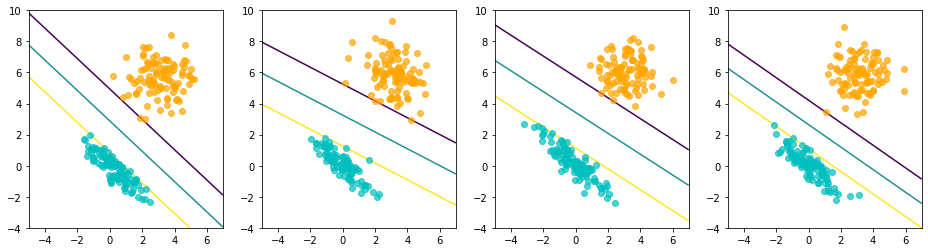

K=10^2


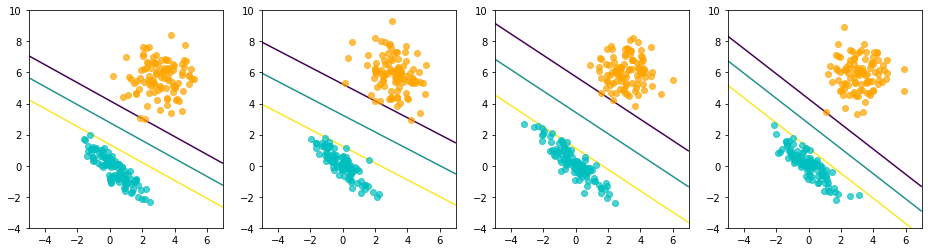

K=10^3


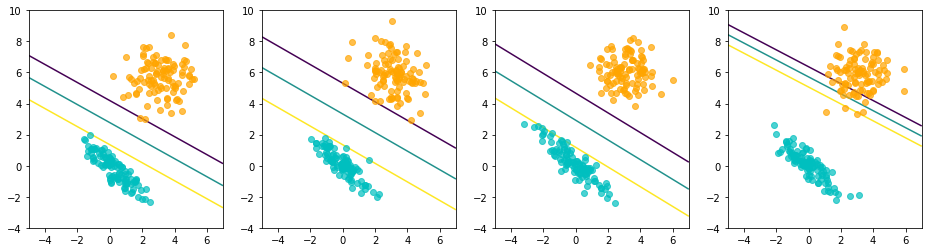

K=10^4


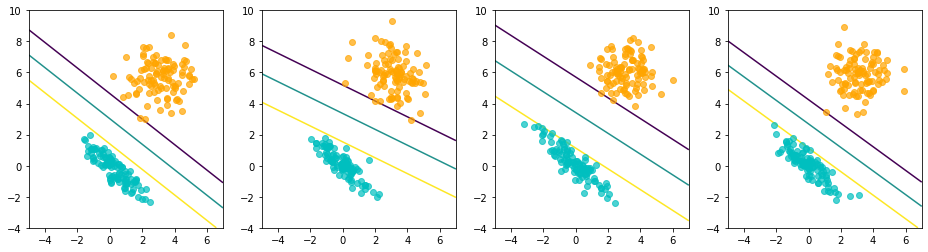

K=10^5


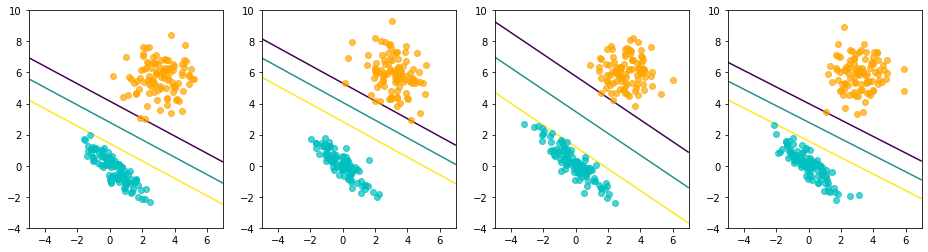

K=10^6


C:\Users\Usuario\Anaconda3\lib\site-packages\matplotlib\contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\Usuario\Anaconda3\lib\site-packages\matplotlib\contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\Users\Usuario\Anaconda3\lib\site-packages\matplotlib\contour.py:1163: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
C:\Users\Usuario\Anaconda3\lib\site-packages\matplotlib\contour.py:1163: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: No contour levels were found within the data range.
  from ipykernel import kernelapp as app


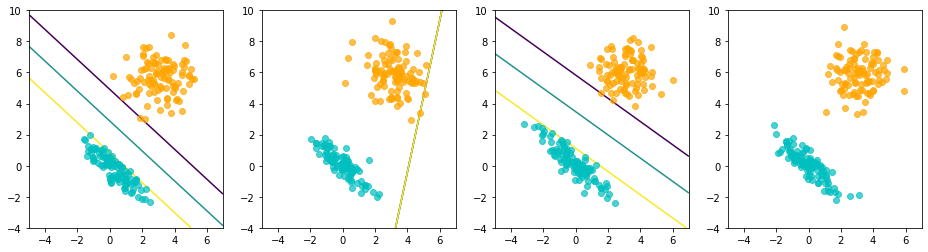

In [41]:
N=100
info = []
info2 = []
info3 = []
info4 = []
info5 = []
info6 = []

for i in range(0,4):
    X, Y, cluster1, cluster2 = generate_dataset(N,True)
    
    K=10
    G, g, A, C, b, d = param(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    newInfo = [cluster1,cluster2,w,b]
    info.append(newInfo)
    
    K=100
    G, g, A, C, b, d = param(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    newInfo = [cluster1,cluster2,w,b]
    info2.append(newInfo)
    
    K=10**3
    G, g, A, C, b, d = param(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    newInfo = [cluster1,cluster2,w,b]
    info3.append(newInfo)
    
    K=10**4
    G, g, A, C, b, d = param(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    newInfo = [cluster1,cluster2,w,b]
    info4.append(newInfo)
    
    K=10**5
    G, g, A, C, b, d = param(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    newInfo = [cluster1,cluster2,w,b]
    info5.append(newInfo)
    
    K=10**6
    G, g, A, C, b, d = param(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    newInfo = [cluster1,cluster2,w,b]
    info6.append(newInfo)

print("K=10")
plot_information = np.array(info)
plot_svm(plot_information)

print("K=10^2")
plot_information = np.array(info2)
plot_svm(plot_information)

print("K=10^3")
plot_information = np.array(info3)
plot_svm(plot_information)

print("K=10^4")
plot_information = np.array(info4)
plot_svm(plot_information)

print("K=10^5")
plot_information = np.array(info5)
plot_svm(plot_information)

print("K=10^6")
plot_information = np.array(info6)
plot_svm(plot_information)

The algorithm works for the larger values of K, this is because we are in the separable case, and since $\alpha$ is not bounded by $K$ in the separable case the result is consistent for all values of $K$. However, we can see that, for high values of $K$, the internal errors of the algorithm cause the result is not as expected. These errors are numerical and rounding errors that occur when working with very large values. This effect occurs from the value $K = 10^{6}$ in most cases. Hence this demonstrated that as $K$ is bounding alpha, when the value of $K$ is relatively lower, it ensures that alpha is therefore lower and hence elminates the aformentioned numerical and rounding errors and ensures that the result is precise enough, while as K gets larger, alpha gets larger which in turn causes these errors.

We can even try with $N=10^{12}$, and we see here that the values are way to high to be computed.

K=10^12


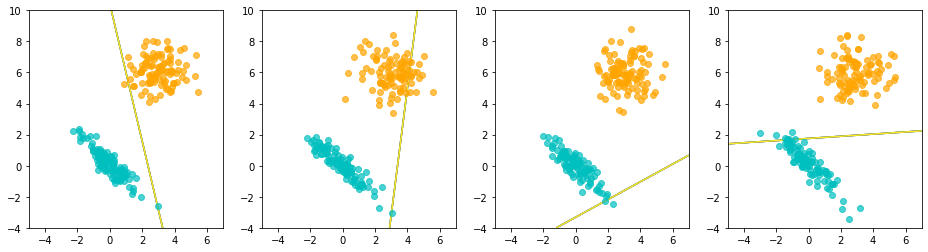

In [42]:
N=100
info = []

for i in range(0,4):
    X, Y, cluster1, cluster2 = generate_dataset(N,True)
    
    K=10**12
    G, g, A, C, b, d = param(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    newInfo = [cluster1,cluster2,w,b]
    info.append(newInfo)

print("K=10^12")
plot_information = np.array(info)
plot_svm(plot_information)

## Non Separable Dataset

We can now try the same experimental values, but with non-separable datasets. 

The principle here is that each point categorized in the wrong group will have a penalty, depending on how far the point is from the margin. Then, the calculus will introduce a new variable which is $\xi$, representing the penalty of each point which is not in the right category. The goal is now to minimize the sum of all the penalties.

Concretely, the algorithm is still the same since we already took into acount this possibility while creating the parameters conversion algorithm.

K=1


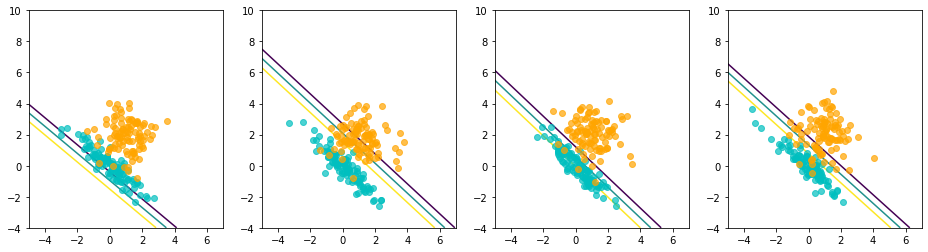

K=10


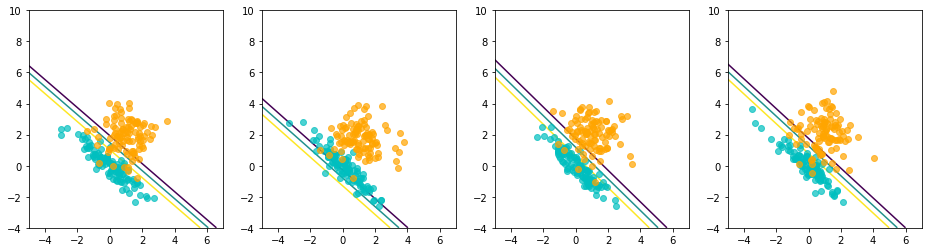

K=10^2


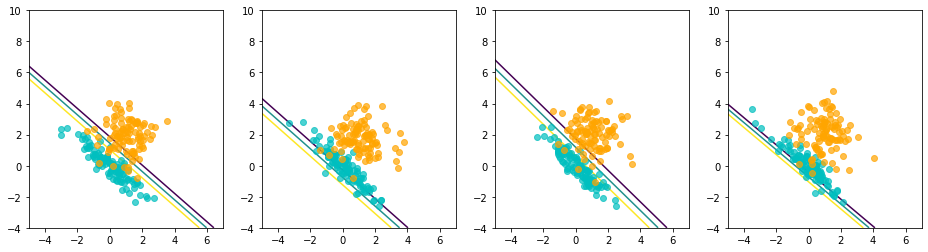

K=10^3


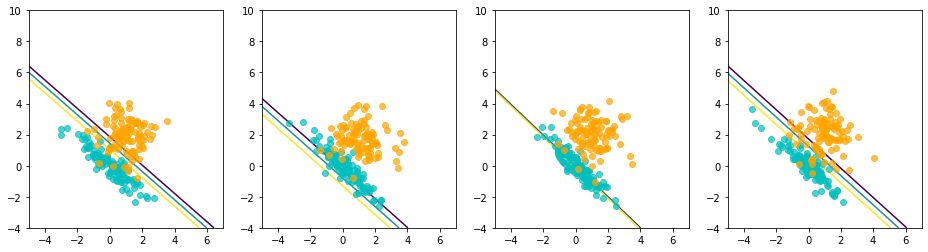

K=10^4


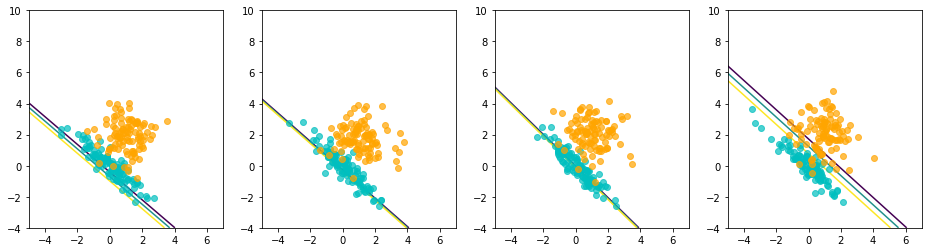

K=10^5


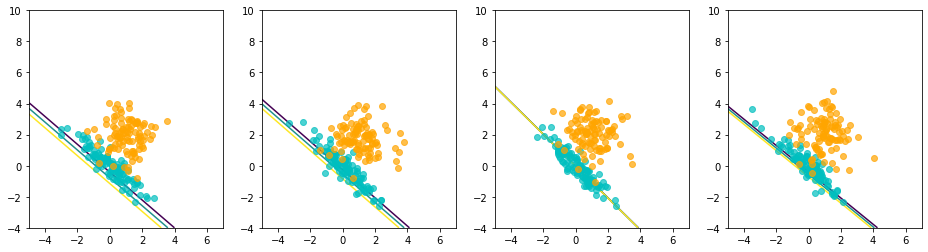

K=10^6


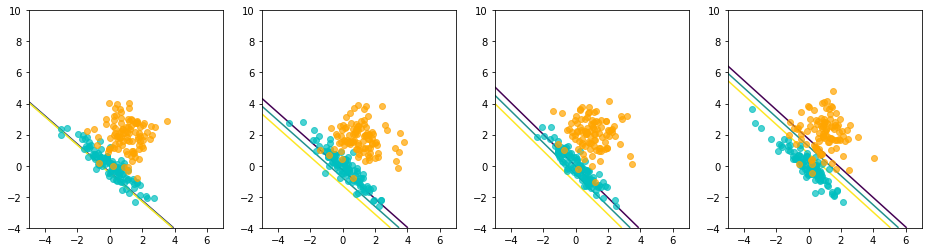

In [43]:
N=100
info = []
info2 = []
info3 = []
info4 = []
info5 = []
info6 = []
info7 = []

for i in range(0,4):
    X, Y, cluster1, cluster2 = generate_dataset(N,False)
    
    K=1
    G, g, A, C, b, d = param(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    newInfo = [cluster1,cluster2,w,b]
    info.append(newInfo)
    
    K=10
    G, g, A, C, b, d = param(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    newInfo = [cluster1,cluster2,w,b]
    info2.append(newInfo)
    
    K=10**2
    G, g, A, C, b, d = param(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    newInfo = [cluster1,cluster2,w,b]
    info3.append(newInfo)
    
    K=10**3
    G, g, A, C, b, d = param(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    newInfo = [cluster1,cluster2,w,b]
    info4.append(newInfo)
    
    K=10**4
    G, g, A, C, b, d = param(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    newInfo = [cluster1,cluster2,w,b]
    info5.append(newInfo)
    
    K=10**5
    G, g, A, C, b, d = param(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    newInfo = [cluster1,cluster2,w,b]
    info6.append(newInfo)
    
    K=10**6
    G, g, A, C, b, d = param(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    newInfo = [cluster1,cluster2,w,b]
    info7.append(newInfo)

print("K=1")
plot_information = np.array(info)
plot_svm(plot_information)

print("K=10")
plot_information = np.array(info2)
plot_svm(plot_information)

print("K=10^2")
plot_information = np.array(info3)
plot_svm(plot_information)

print("K=10^3")
plot_information = np.array(info4)
plot_svm(plot_information)

print("K=10^4")
plot_information = np.array(info5)
plot_svm(plot_information)

print("K=10^5")
plot_information = np.array(info6)
plot_svm(plot_information)

print("K=10^6")
plot_information = np.array(info7)
plot_svm(plot_information)

The algorithm seems to work with K=1, separating the dataset in two optimal categories with very few violations. However the algorithm is not perfect, we can see that even with K=1 the algorithm will tend to give more importance to the violations of the orange category. Indeed, the K value represents the importance of each violation, since the penalty is given by: 
$K\sum\xi_i$

Then, if the given importance is too high, as it is the case with $K=10^3$ for instance, the equation can be imbalanced and give wrong or non-optimal values.

Because of that, the categorization could be improved. 

With a very high value of K, we can even see that these mistakes are worth since the results are less and less precise. Runtime errors also occur at this moment, meaning that the values are too high to be computed by Python. Because of that, as in the experiment with the separable dataset, some of the last experiments with K=10^6 can't be computed.

# Lab5: Stochastic gradient descent for SVM

We will now use the stochastic gradient descent, that calculates the error in order to update the model for each example in the training dataset.

## 1: Simple stochastic gradient descent

In [102]:
def log_f(w, b, x, y, lam):
    cond = np.where(1. - y*(np.dot(x, w) + b) < 0, 0, 1. - y*(np.dot(x, w) + b))
    
    log_f_ = lam/2. * np.dot(w, w.T) + sum(cond)
    return(log_f_)

In [103]:
def grad_desc(w, b, gam, lam, x, y):
    w = w - (gam*lam*w)
    if y*(np.dot(x, w) + b) <= 1:
        w = w + gam*y*x
        b = b + gam*y
    return w, b

In [104]:
def stoch_grad_desc(x, y, lam, iters, mu):
    
    w = np.zeros(2) 
    best_w = w
    b = 0
    best_b = b
    
    best_point_seq = []
    best_point = log_f(w, b, x, y, lam)
    best_point_seq.append(best_point)
    log_func = []
    
    for it in range(iters): 
       
        x_post, y_post = shuffle(x, y)
        
        for i in range(x_post.shape[0]): 
            
            x_sample = x_post[i, :]
            y_sample = y_post[i]

            w, b = grad_desc(w, b, 1./mu, lam, x_sample, y_sample)
       
        log_f_ = log_f(w, b, x, y, lam)
        
        
        if log_f_ < best_point:  
            best_point = log_f_
            best_w = w
            best_b = b   
            
        best_point_seq.append(best_point) 
        log_func.append(np.log(best_point))
        
        mu = mu + 1
        
    return best_w, best_b, best_point_seq, log_func

In [105]:
N = 100
X, Y, cluster1, cluster2 = generate_dataset(N,True)
X = X.T
Y = np.diag(Y)
X.shape, Y.shape, cluster1.shape, cluster2.shape

((200, 2), (200,), (100, 2), (100, 2))

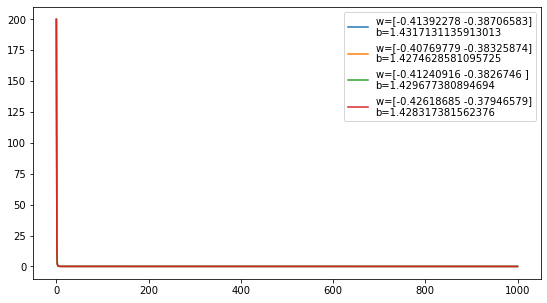

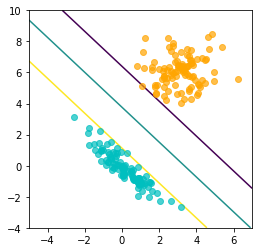

In [106]:
mu = 100
lam = 1e-4
iters = 1000

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)

for i in range(4):
    w, b, best_point_seq, log_func = stoch_grad_desc(X, Y, lam, iters, mu)
    ax.plot(best_point_seq, label='w='+str(w)+"\nb="+str(b)) 
ax.legend()

plot_information = np.array([[cluster1, cluster2, w, b]])
plot_svm(plot_information)
plt.show()

## 2: Stochastic mini batch 

This method consists in separating the dataset in several little batches, and then calculate the errors sum of the entiere batch. Then, we first need to divide the data set into several mini-batches. The batch size is a parameter of the function, so that it could evolve in order to try different values. 

In [107]:
def grad_desc_mini_batch(w, b, gam, lam, x, y):
    
    w = w - (gam*lam*w)
    
    for i in range(len(x)):
        sum_x_y=0
        sum_y=0
        
        if y[i]*(np.dot(x[i], w) + b) <= 1:
            sum_x_y+=(y[i]*x[i,:])
            sum_y+=y[i]
            
        w = w + gam*sum_x_y
        b = b + gam*sum_y
        
    return w, b

In [108]:
def construct_mini_batches(x, y, batch_size):
    x_batches=[]
    y_batches=[]
    
    for i in range(int(len(x)/batch_size)):
        new_x_batch=x[i:i+batch_size-1]
        new_y_batch=y[i:i+batch_size-1]
        x_batches.append(new_x_batch)
        y_batches.append(new_y_batch)
        
    return x_batches, y_batches

In [109]:
def stoch_mini_batch(x, y, lam, iters, mu, batch_size):
    
    w = np.zeros(2) 
    best_w = w
    b = 0
    best_b = b
    
    best_point_seq = []
    best_point = log_f(w, b, x, y, lam)
    best_point_seq.append(best_point)
    log_func = []
    
    for it in range(iters): 
       
        x_post, y_post = shuffle(x, y)
        x_batches, y_batches = construct_mini_batches(x_post, y_post, batch_size)
        
        for i in range(len(x_batches)): 
            
            x_batch = x_batches[i]
            y_batch = y_batches[i]

            w, b = grad_desc_mini_batch(w, b, 1./mu, lam, x_batch, y_batch)
       
        log_f_ = log_f(w, b, x, y, lam)
        
        
        if log_f_ < best_point:  
            best_point = log_f_
            best_w = w
            best_b = b   
            
        best_point_seq.append(best_point) 
        log_func.append(np.log(best_point))
        
        mu = mu + 1
        
    return best_w, best_b, best_point_seq, log_func

In [110]:
def mini_batch_experiment(batch_size,X,Y, cluster1, cluster2):
    
    X = X.T
    Y = np.diag(Y)
    X.shape, Y.shape, cluster1.shape, cluster2.shape

    mu = 100
    lam = 1e-4
    iters = 1000

    for i in range(4):
        w, b, best_point_seq, log_func = stoch_mini_batch(X, Y, lam, iters, mu, batch_size)
        ax.plot(best_point_seq, label='w='+str(w)+"\nb="+str(b)) 

    plot_information = [cluster1, cluster2, w, b]
    return plot_information

N=10


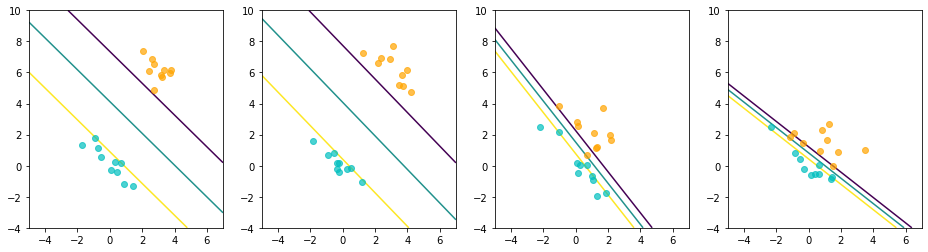

N=50


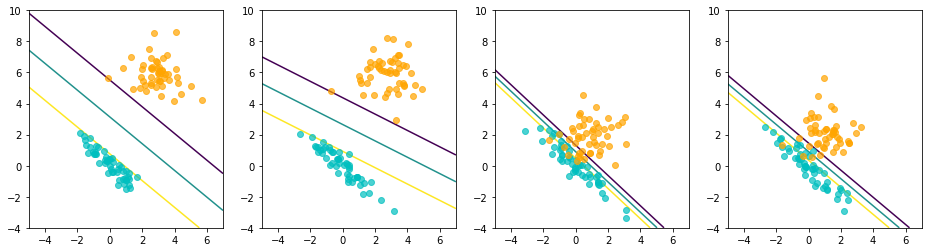

N=100


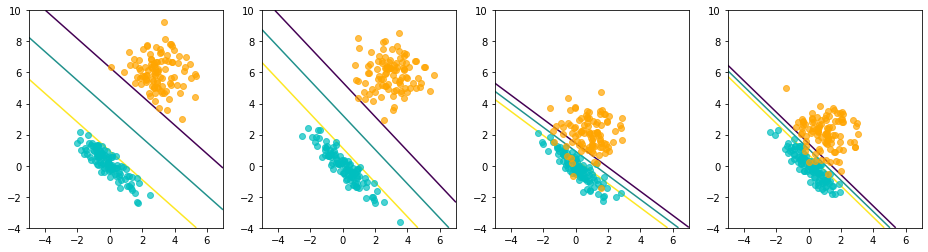

In [111]:
# Try with different N values, and a batch size of 10

batch_size = 10

info = []
info2 = []
info3 = []

for i in range(0,2):
    
    N=10   
    X, Y, cluster1, cluster2 = generate_dataset(N,True)
    newInfo = mini_batch_experiment(batch_size, X, Y, cluster1, cluster2)
    info.append(newInfo)
    
    N=50    
    X, Y, cluster1, cluster2 = generate_dataset(N,True)
    newInfo = mini_batch_experiment(batch_size, X, Y, cluster1, cluster2)
    info2.append(newInfo)
    
    N=100    
    X, Y, cluster1, cluster2 = generate_dataset(N,True)
    newInfo = mini_batch_experiment(batch_size, X, Y, cluster1, cluster2)
    info3.append(newInfo)
    
for i in range(0,2):
    
    N=10
    X, Y, cluster1, cluster2 = generate_dataset(N,False)
    newInfo = mini_batch_experiment(batch_size, X, Y, cluster1, cluster2)
    info.append(newInfo)
    
    N=50    
    X, Y, cluster1, cluster2 = generate_dataset(N,False)
    newInfo = mini_batch_experiment(batch_size, X, Y, cluster1, cluster2)
    info2.append(newInfo)
    
    N=100    
    X, Y, cluster1, cluster2 = generate_dataset(N,False)
    newInfo = mini_batch_experiment(batch_size, X, Y, cluster1, cluster2)
    info3.append(newInfo)
    

print("N=10")
plot_information = np.array(info)
plot_svm(plot_information)

print("N=50")
plot_information = np.array(info2)
plot_svm(plot_information)

print("N=100")
plot_information = np.array(info3)
plot_svm(plot_information)

We tried here to represent several generated datasets, with N value equal to 10, 50 or 100. For the moment, the batch size is always equal to 10. The other parameters ($\mu, \gamma, \lambda$) that were changed in the previous experiment are also static now, since we do not try to calculate their impact. Two separable and two non-separable datasets are used for this experiment.

As we can see, the algorithm seems to work well for every N value, whether it is a separable or a non-separable dataset.

We will now only focus on the datasets composed of 2*100 values, wich means N=100. We will try different values for the batch size, such as 10, 20 and 50.

Batch size = 10


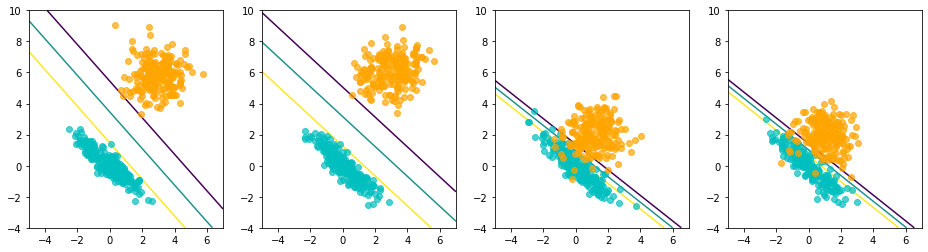

Batch size = 20


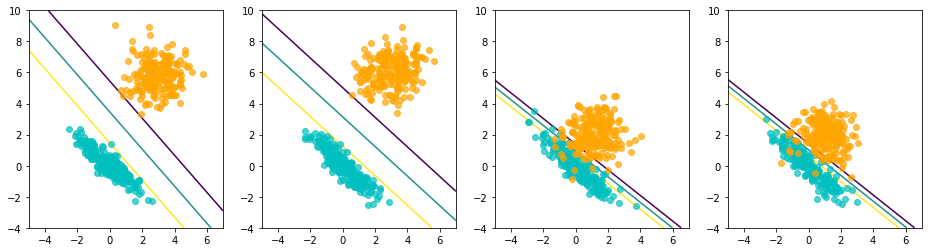

Batch size = 50


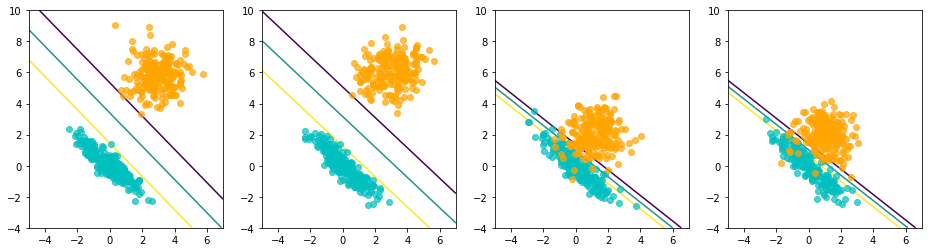

In [55]:
# Try with different batch size values, and N = 200

N = 200

info = []
info2 = []
info3 = []

for i in range(0,2):
      
    X, Y, cluster1, cluster2 = generate_dataset(N,True)
    
    batch_size=10    
    newInfo = mini_batch_experiment(batch_size, X, Y, cluster1, cluster2)
    info.append(newInfo)
    
    batch_size=20   
    newInfo = mini_batch_experiment(batch_size, X, Y, cluster1, cluster2)
    info2.append(newInfo)
    
    batch_size=50    
    newInfo = mini_batch_experiment(batch_size, X, Y, cluster1, cluster2)
    info3.append(newInfo)
    
for i in range(0,2):
    
    X, Y, cluster1, cluster2 = generate_dataset(N,False)
    
    batch_size=10    
    newInfo = mini_batch_experiment(batch_size, X, Y, cluster1, cluster2)
    info.append(newInfo)
    
    batch_size=20    
    newInfo = mini_batch_experiment(batch_size, X, Y, cluster1, cluster2)
    info2.append(newInfo)
    
    batch_size=50    
    newInfo = mini_batch_experiment(batch_size, X, Y, cluster1, cluster2)
    info3.append(newInfo)
    

print("Batch size = 10")
plot_information = np.array(info)
plot_svm(plot_information)

print("Batch size = 20")
plot_information = np.array(info2)
plot_svm(plot_information)

print("Batch size = 50")
plot_information = np.array(info3)
plot_svm(plot_information)

## 3: Logarithm of function at each iteration

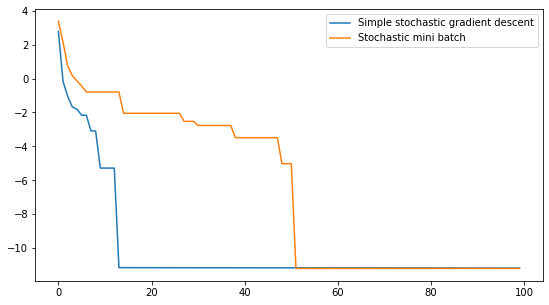

In [101]:
mu = 100
lam = 1e-4
iters = 100

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)

w, b, best_point_seq, log_func_1 = stoch_grad_desc(X, Y, lam, iters, mu)
ax1.plot(log_func_1, label="Simple stochastic gradient descent")

w, b, best_point_seq, log_func_2 = stoch_mini_batch(X, Y, lam, iters, mu, batch_size)
ax1.plot(log_func_2, label="Stochastic mini batch")
ax1.legend()

#plot_information = np.array([[cluster1, cluster2, w, b]])
#plot_svm(plot_information)
plt.show()